## Imports

In [1]:
pip install category_encoders

In [2]:
pip install catboost

In [59]:
import pandas as pd
import numpy as np
import pickle
import time

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,log_loss,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,HistGradientBoostingClassifier,AdaBoostClassifier

In [6]:
df = pd.read_parquet('wnba_shot_data.parquet')
players = pd.read_parquet('wnba_player_data_updated.parquet')

## Preprocessing

In [7]:
TEAMS = {
    'Atlanta Dream':'ATL',
    'Charlotte Sting':'CHA',
    'Chicago Sky':'CHI',
    'Cleveland Rockers':'CLE',
    'Connecticut Sun':'CON',
    'Dallas Wings':'DAL',
    'Detroit Shock':'DET',
    'Houston Comets':'HOU',
    'Indiana Fever':'IND',
    'Las Vegas Aces':'LVA',
    'Los Angeles Sparks':'LAS',
    'Miami Sol':'MIA',
    'Minnesota Lynx':'MIN',
    'New York Liberty':'NYL',
    'Orlando Miracle':'ORL',
    'Phoenix Mercury':'PHO',
    'Portland Fire':'POR',
    'Sacramento Monarchs':'SAC',
    'San Antonio Silver Stars':'SAN',
    'San Antonio Stars':'SAN',
    'Seattle Storm':'SEA',
    'Tulsa Shock':'TUL',
    'Utah Starzz':'UTA',
    'Washington Mystics':'WAS'
 }

df = df.merge(players[['player_id','primary_position']],on='player_id')

df = df.loc[~(df.action_type=='No Shot')].copy()
df.year = df.year.astype(int)

# df = df.loc[df.year >=2006].copy()

df['era'] = 0
df.loc[(df.year.between(1997,2000)), ['era']] = 1
df.loc[(df.year.between(2001,2004)), ['era']] = 2
df.loc[(df.year.between(2005,2008)), ['era']] = 3
df.loc[(df.year.between(2009,2012)), ['era']] = 4
df.loc[(df.year.between(2013,2016)), ['era']] = 5
df.loc[(df.year>=2017), ['era']] = 6
df  = pd.get_dummies(df, columns=['era'])


df['home'] = np.where(df.team_name.map(TEAMS) == df.htm,1,0)

df['buzzer'] = (np
                .where(
                    (df.minutes_remaining == 0) &
                    (df.seconds_remaining < 1),
                    1,
                    0
                    )
                )

df['bubble'] = (np
                .where(
                    (df.year == 2020),
                    1,
                    0
                    )
                )

df['p_sec_rem'] = ((df.minutes_remaining * 60) + (df.seconds_remaining))

# df['time'] = None
# def secondsPlayed(df):
#   if df.year >= 2006:
#     if df.period == 1:
#       df['time'] = 600 - df.p_sec_rem
#     elif (df.period > 1) & (df.period < 5):
#       df['time'] = ((df.period * 10) * 60) - df.p_sec_rem
#     elif df.period == 5:
#       df['time'] = (((4 * 10) * 60) + 300) - df.p_sec_rem
#     elif df.period == 6:
#       df['time'] = (((4 * 10) * 60) + 600) - df.p_sec_rem
#     elif df.period == 7:
#       df['time'] = (((4 * 10) * 60) + 900) - df.p_sec_rem
#   elif df.year <= 2005:
#     if df.period == 1:
#       df['time'] = 1200 - df.p_sec_rem
#     elif df.period == 2:
#       df['time'] = 2400 - df.p_sec_rem
#     elif df.period == 3:
#       df['time'] = (((2 * 20) * 60) + 300) - df.p_sec_rem
#     elif df.period == 4:
#       df['time'] = (((2 * 20) * 60) + 600) - df.p_sec_rem
#     elif df.period == 5:
#       df['time'] = (((2 * 20) * 60) + 900) - df.p_sec_rem
#     elif df.period == 6:
#       df['time'] = (((2 * 20) * 60) + 1200) - df.p_sec_rem
#     elif df.period == 7:
#       df['time'] = (((2 * 20) * 60) + 1500) - df.p_sec_rem

#   return df

# df = df.apply(secondsPlayed,axis=1)

df['time'] = (np
                .where(df['year']<=2005, 
                      np.where(df['period']==1, 
                                1200, 1800 + 300*df['period']), 
                      np.where(df['period']<5, 
                                df['period']*600, 1200 + 300*df['period'])
                      )
                - df['p_sec_rem']
                )

df = df.sort_values(by=['player_id','game_date'])
df['gp'] = (df.game_id) != (df.game_id.shift())
df['gp'] = df.groupby('player_id').gp.cumsum().sort_index()

# no idea why the code doesn't work correctly for this player, but mannually fixing it here
df.gp = np.where(
    df.player_id==1627644,
    df.gp+1,
    df.
    gp
    )

# df = df.sort_values(by=['player_id','gp','time'])
# df['shot_zone_avg'] = df.groupby(['player_id', 'shot_zone_basic'])['shot_made_flag'].expanding().mean().droplevel([0,1]).round(2)
# df['shot_zone_avg'] = df.groupby(['player_id', 'shot_zone_basic'])['shot_made_flag'].expanding().mean().groupby(level=[0,1]).shift().droplevel([0,1]).round(2)
# df.shot_zone_avg = df.shot_zone_avg.fillna(0)

df.action_type = (np
                .where(
                    (df.shot_distance == 0) &
                    (df.shot_type == '3PT Field Goal'),
                    'Layup Shot',
                    df.action_type
                    )
                )

df.action_type = (np
                .where(
                    (df.shot_distance > 0) &
                    (df.shot_distance < 19 ) &
                    (df.shot_type == '3PT Field Goal'),
                    'Jump Shot',
                    df.action_type
                    )
                )

df.shot_zone_basic = (np
                .where(
                    (df.shot_distance == 0) &
                    (df.shot_type == '3PT Field Goal'),
                    'Restricted Area',
                    df.shot_zone_basic
                    )
                )

df.shot_zone_basic = (np
                .where(
                    (df.shot_distance > 0) &
                    (df.shot_distance < 19 ) &
                    (df.shot_type == '3PT Field Goal'),
                    'Mid-Range',
                    df.shot_zone_basic
                    )
                )

df.shot_type = (np
                .where(
                    (df.shot_distance < 19) &
                    (df.shot_type == '3PT Field Goal'),
                    '2PT Field Goal',
                    df.shot_type
                    )
                )

# df.action_type = (np
#                   .where(
#                       df.action_type.str.contains('Dunk'),
#                       'Dunk',
#                       df.action_type
#                       )
#                   )

## Benchmarking different models

### Testing on random split

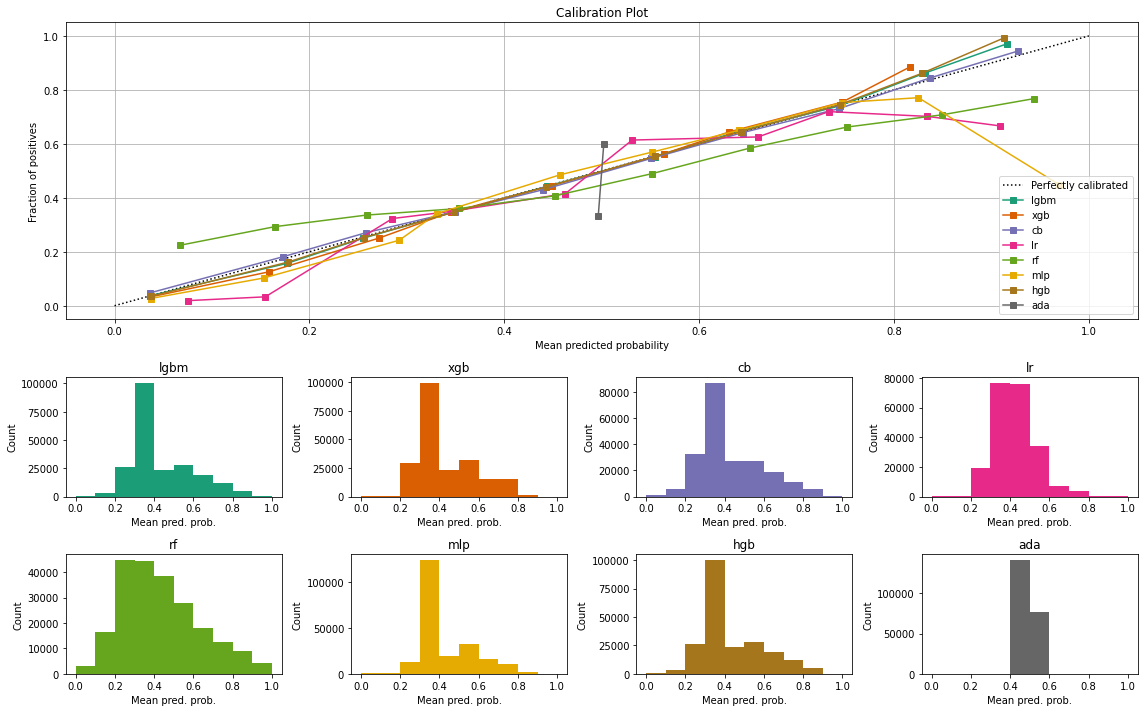

In [8]:
X = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y = df['shot_made_flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clfs = [
        (LGBMClassifier(),'lgbm'),
        (XGBClassifier(),'xgb'),
        (CatBoostClassifier(verbose=False),'cb'),
        (LogisticRegression(max_iter=1000),'lr'),
        (RandomForestClassifier(),'rf'),
        (MLPClassifier(),'mlp'),
        (HistGradientBoostingClassifier(),'hgb'),
        (AdaBoostClassifier(),'ada'),
        ]

models = pd.DataFrame()

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 4)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :4])
calibration_displays = {}

for i, (clf, name) in enumerate(clfs):
    pipe = make_pipeline(ce.OrdinalEncoder(), clf)
    start = time.process_time()
    pipe.fit(X_train, y_train)
    end = time.process_time()

    display = CalibrationDisplay.from_estimator(
        pipe,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

    preds = pipe.predict_proba(X_test)

    acc = accuracy_score(y_test,np.round(preds[:,1]))
    ll = log_loss(y_test,preds[:,1])
    p = precision_score(y_test,np.round(preds[:,1]))
    r = recall_score(y_test,np.round(preds[:,1]))
    f1 = f1_score(y_test,np.round(preds[:,1]))
    ra = roc_auc_score(y_test,np.round(preds[:,1]))
    cal = np.absolute((display.prob_pred - display.prob_true).mean())
    t = round(end-start,2)

    model = pd.DataFrame(
        {
          'accuracy':[acc],
          'logloss':[ll],
          'precision':[p],
          'recall':[r],
          'f1':[f1],
          'roc_auc':[ra],
          'cal':[cal],
          'time':[t]
        }
        ,index=[name])

    models = models.append(model)

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot")

grid_positions = [
                  (2, 0), (2, 1), (2, 2), (2, 3),
                  (3, 0), (3, 1), (3, 2), (3, 3)
                  ]

for i, (_, name) in enumerate(clfs):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean pred. prob.", ylabel="Count")

plt.tight_layout()

In [9]:
models

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
lgbm,0.654910,0.629308,0.641142,0.437452,0.520064,0.627342,0.005813,14.68
xgb,0.652333,0.633075,0.635171,0.438353,0.518720,0.625206,0.003199,31.83
cb,0.654443,0.629901,0.638691,0.440961,0.521719,0.627378,0.002405,170.13
lr,0.625723,0.659249,0.626218,0.308385,0.413258,0.585492,0.052404,22.30
rf,0.628782,0.671748,0.589792,0.431775,0.498563,0.603806,0.021339,137.90
mlp,0.644784,0.641095,0.628740,0.412460,0.498137,0.615331,0.061405,2080.72
hgb,0.654851,0.629451,0.640803,0.437956,0.520308,0.627354,0.008765,15.74
ada,0.643133,0.690883,0.600436,0.493347,0.541649,0.624144,0.032211,23.24


### Checking train scores to see if any models are overfitting
omitting mlp because it took exponentially longer and wasn't even better. replacing with `GaussianNB`

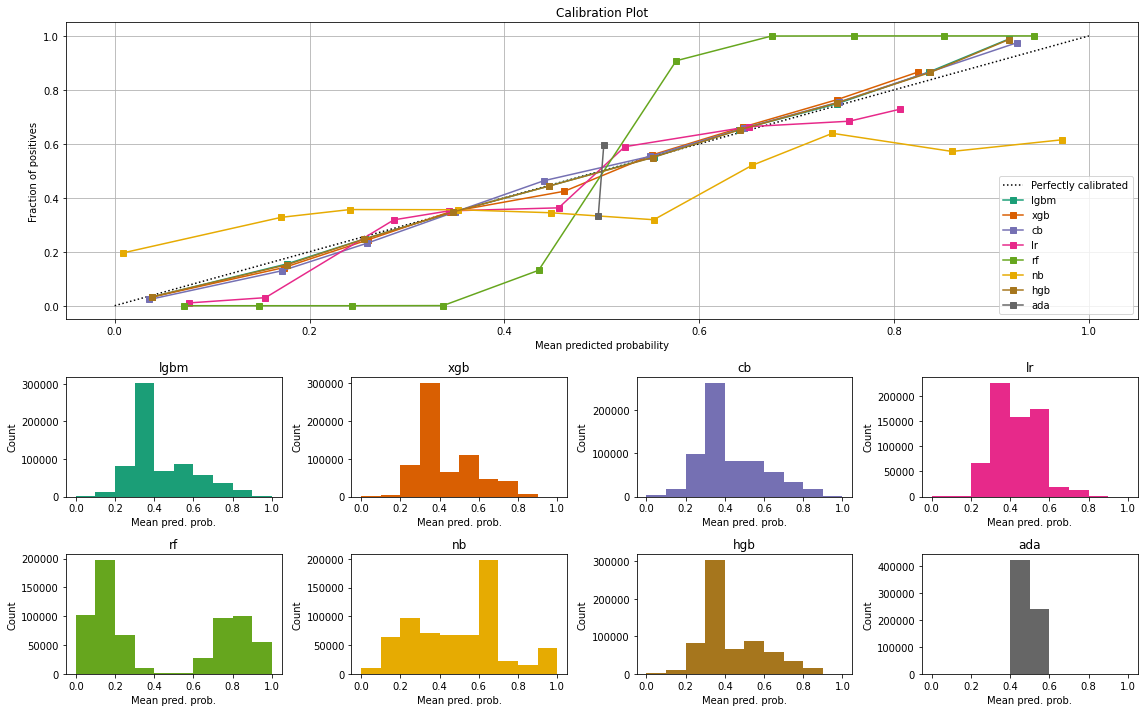

In [11]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

clfs = [
        (LGBMClassifier(),'lgbm'),
        (XGBClassifier(),'xgb'),
        (CatBoostClassifier(verbose=False),'cb'),
        (LogisticRegression(max_iter=1000),'lr'),
        (RandomForestClassifier(),'rf'),
        (GaussianNB(),'nb'),
        (HistGradientBoostingClassifier(),'hgb'),
        (AdaBoostClassifier(),'ada'),
        ]

models = pd.DataFrame()

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 4)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :4])
calibration_displays = {}

for i, (clf, name) in enumerate(clfs):
    pipe = make_pipeline(ce.OrdinalEncoder(), clf)
    start = time.process_time()
    pipe.fit(X_train, y_train)
    end = time.process_time()

    display = CalibrationDisplay.from_estimator(
        pipe,
        X_train,
        y_train,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

    preds = pipe.predict_proba(X_train)

    acc = accuracy_score(y_train,np.round(preds[:,1]))
    ll = log_loss(y_train,preds[:,1])
    p = precision_score(y_train,np.round(preds[:,1]))
    r = recall_score(y_train,np.round(preds[:,1]))
    f1 = f1_score(y_train,np.round(preds[:,1]))
    ra = roc_auc_score(y_train,np.round(preds[:,1]))
    cal = np.absolute((display.prob_pred - display.prob_true).mean())
    t = round(end-start,2)

    model = pd.DataFrame(
        {
          'accuracy':[acc],
          'logloss':[ll],
          'precision':[p],
          'recall':[r],
          'f1':[f1],
          'roc_auc':[ra],
          'cal':[cal],
          'time':[t]
        }
        ,index=[name])

    models = models.append(model)

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot")

grid_positions = [
                  (2, 0), (2, 1), (2, 2), (2, 3),
                  (3, 0), (3, 1), (3, 2), (3, 3)
                  ]

for i, (_, name) in enumerate(clfs):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean pred. prob.", ylabel="Count")

plt.tight_layout()
plt.show()

In [13]:
models

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
lgbm,0.656878,0.626466,0.644334,0.442628,0.524766,0.629907,0.007794,9.64
xgb,0.654061,0.631847,0.632433,0.457781,0.531117,0.629353,0.000072,49.22
cb,0.662788,0.616284,0.654048,0.450284,0.533367,0.636037,0.004447,249.63
lr,0.635544,0.658963,0.601753,0.438972,0.507632,0.610799,0.034921,10.61
rf,0.999687,0.181558,0.999597,0.999671,0.999634,0.999685,0.000065,188.00
nb,0.575563,0.865951,0.503352,0.623935,0.557194,0.581652,0.075303,1.09
hgb,0.656625,0.626468,0.642994,0.444520,0.525646,0.629925,0.007150,22.91
ada,0.642311,0.690884,0.597190,0.504668,0.547045,0.624984,0.034582,34.87


RF extremely ovefits. Gradient boosting methods are by far the best (no surprise). Let's take a better look at them

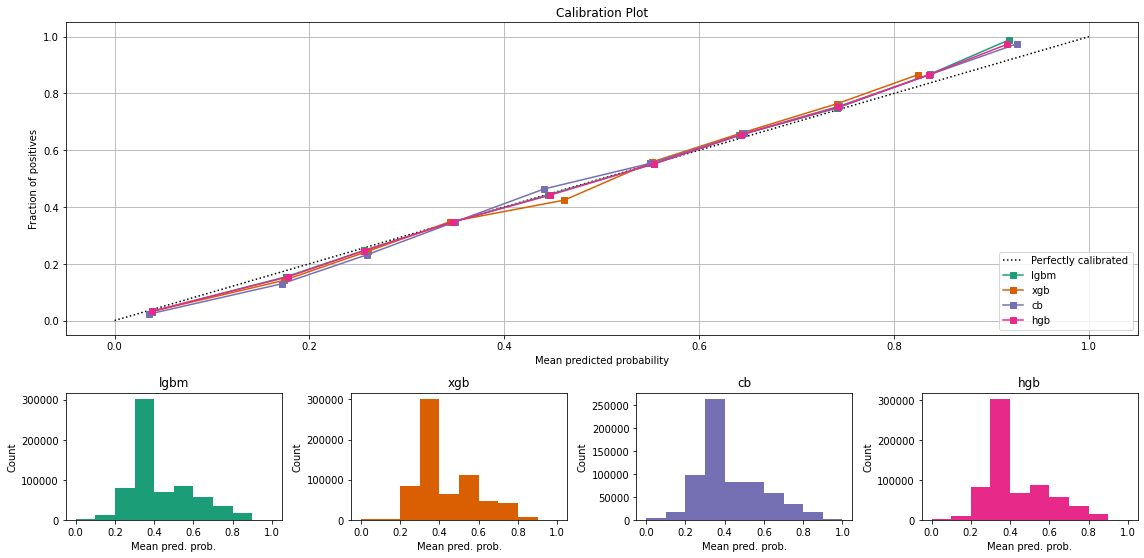

In [15]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

clfs = [
        (LGBMClassifier(),'lgbm'),
        (XGBClassifier(),'xgb'),
        (CatBoostClassifier(verbose=False),'cb'),
        (HistGradientBoostingClassifier(),'hgb'),
        ]

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(4, 4)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :4])
calibration_displays = {}

models = pd.DataFrame()

for i, (clf, name) in enumerate(clfs):
    pipe = make_pipeline(ce.OrdinalEncoder(), clf)
    start = time.process_time()
    pipe.fit(X_train, y_train)
    end = time.process_time()

    display = CalibrationDisplay.from_estimator(
        pipe,
        X_train,
        y_train,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

    preds = pipe.predict_proba(X_train)

    acc = accuracy_score(y_train,np.round(preds[:,1]))
    ll = log_loss(y_train,preds[:,1])
    p = precision_score(y_train,np.round(preds[:,1]))
    r = recall_score(y_train,np.round(preds[:,1]))
    f1 = f1_score(y_train,np.round(preds[:,1]))
    ra = roc_auc_score(y_train,np.round(preds[:,1]))
    cal = np.absolute((display.prob_pred - display.prob_true).mean())
    t = round(end-start,2)

    model = pd.DataFrame(
        {
          'accuracy':[acc],
          'logloss':[ll],
          'precision':[p],
          'recall':[r],
          'f1':[f1],
          'roc_auc':[ra],
          'cal':[cal],
          'time':[t]
        }
        ,index=[name])

    models = models.append(model)

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration Plot")

grid_positions = [
                  (2, 0), (2, 1), (2, 2), (2, 3),
                  (3, 0), (3, 1), (3, 2), (3, 3)
                  ]

for i, (_, name) in enumerate(clfs):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean pred. prob.", ylabel="Count")

plt.tight_layout()
plt.show()

In [16]:
# should have same results
models

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
lgbm,0.656878,0.626466,0.644334,0.442628,0.524766,0.629907,0.007794,9.61
xgb,0.654061,0.631847,0.632433,0.457781,0.531117,0.629353,0.000072,53.75
cb,0.662788,0.616284,0.654048,0.450284,0.533367,0.636037,0.004447,249.23
hgb,0.656902,0.626563,0.643501,0.444750,0.525976,0.630196,0.006037,22.94


Gradient boosting models are #good

## Tuning LGBM

In [36]:
X_train = df[['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']]
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())

params = {
    "lgbmclassifier__objective" : ['binary'],
    "lgbmclassifier__max_depth" : [1,3,6,9,12,15],
    "lgbmclassifier__learning_rate" : [0.01, 0.05, 0.1, 0.2, 0.3,0.4],
    "lgbmclassifier__num_leaves" : [100,300,500,700,1000],
    "lgbmclassifier__n_estimators":[100,300,500,700,1000],
    "lgbmclassifier__boosting":['gbdt']
}

search=RandomizedSearchCV(pipe,
                   params,
                   n_iter=10,
                   scoring='neg_log_loss',
                   n_jobs=-1,
                   cv=5,
                   random_state=42, verbose=2
                   )

In [37]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('lgbmclassifier',
                                              LGBMClassifier())]),
                   n_jobs=-1,
                   param_distributions={'lgbmclassifier__boosting': ['gbdt'],
                                        'lgbmclassifier__learning_rate': [0.01,
                                                                          0.05,
                                                                          0.1,
                                                                          0.2,
                                                                          0.3,
                                                                          0.4],
                                        'lgbmclassifier__max_depth': [1, 3, 6,
                                                   

In [38]:
print(search.cv_results_['mean_test_score'].mean())
print(search.cv_results_['mean_test_score'].std())
print(search.cv_results_['mean_test_score'])

-0.6607374917113684
0.03324304372415434
[-0.63594135 -0.66431029 -0.64327237 -0.73751231 -0.63669343 -0.69455582
 -0.68681053 -0.63579005 -0.63594135 -0.63654741]


In [39]:
params_ = search.best_params_
params_

{'lgbmclassifier__boosting': 'gbdt',
 'lgbmclassifier__learning_rate': 0.01,
 'lgbmclassifier__max_depth': 12,
 'lgbmclassifier__n_estimators': 500,
 'lgbmclassifier__num_leaves': 100,
 'lgbmclassifier__objective': 'binary'}

## LOSO testing boosting methods and tuned lgbm

In [36]:
# takes two hours to run

df_pred = pd.DataFrame()
df_actual = pd.DataFrame()

models = {}

years = np.arange(df.year.min(),df.year.max()+1)

groups = df['year']

X = df[
       ['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3','era_4',
        'era_5','era_6','home','gp','time','buzzer','bubble','primary_position']
       ]
y = df['shot_made_flag']

logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

logo.get_n_splits(groups=groups)

clfs = [
        (HistGradientBoostingClassifier(),'hgb'),
        (LGBMClassifier(),'lgbm'),
        (XGBClassifier(),'xgb'),
        (CatBoostClassifier(verbose=False),'cb'),
        (LGBMClassifier(
            boosting='gbdt',
            learning_rate=0.01,
            max_depth=12,
            n_estimators=500,
            num_leaves=100,
            objective='binary'
            ),'lgbm_tuned')
        ]
for clf, name in clfs:
  print(f'Running {clf}...')
  model_i = pd.DataFrame()
  for year, (train_index, test_index) in zip(years, logo.split(X, y, groups)):
    print(f'Leaving out {year}...')
    
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
    pipe = make_pipeline(ce.OrdinalEncoder(), clf)
    
    start = time.process_time()
    pipe.fit(X_train, y_train)
    end = time.process_time()

    display = CalibrationDisplay.from_estimator(
          pipe,
          X_test,
          y_test,
          n_bins=10,
      )
    plt.close()

    try:
      imps = list(dict(zip(pipe.steps[1][1].feature_importances_,X_test.columns)).items()) 
    except AttributeError:
      imps = ['No feature importance for this model']
    

    X_test["make_pred"] = (pd.
                          DataFrame(
                              pipe.predict_proba(X_test),
                              index=X_test.index,
                              columns=[0,"make_pred"])[["make_pred"]]
                           )

    ll = log_loss(y_test,X_test["make_pred"]) 
    acc = accuracy_score(y_test,np.round(X_test["make_pred"]))
    p = precision_score(y_test,np.round(X_test["make_pred"]))
    r = recall_score(y_test,np.round(X_test["make_pred"]))
    f1 = f1_score(y_test,np.round(X_test["make_pred"]))
    ra = roc_auc_score(y_test,np.round(X_test["make_pred"]))
    cal = np.absolute((display.prob_pred - display.prob_true).mean())
    t = round(end-start,2)

    group = pd.DataFrame(
      {
        'accuracy':[acc],
        'logloss':[ll],
        'precision':[p],
        'recall':[r],
        'f1':[f1],
        'roc_auc':[ra],
        'cal':[cal],
        'time':[t],
        'imps':[imps]
      }
      ,index=[year])

    model_i = model_i.append(group)

    models[f'df_{name}'] = model_i

Running HistGradientBoostingClassifier()...
Leaving out 1997...
Leaving out 1998...
Leaving out 1999...
Leaving out 2000...
Leaving out 2001...
Leaving out 2002...
Leaving out 2003...
Leaving out 2004...
Leaving out 2005...
Leaving out 2006...
Leaving out 2007...
Leaving out 2008...
Leaving out 2009...
Leaving out 2010...
Leaving out 2011...
Leaving out 2012...
Leaving out 2013...
Leaving out 2014...
Leaving out 2015...
Leaving out 2016...
Leaving out 2017...
Leaving out 2018...
Leaving out 2019...
Leaving out 2020...
Leaving out 2021...
Running LGBMClassifier()...
Leaving out 1997...
Leaving out 1998...
Leaving out 1999...
Leaving out 2000...
Leaving out 2001...
Leaving out 2002...
Leaving out 2003...
Leaving out 2004...
Leaving out 2005...
Leaving out 2006...
Leaving out 2007...
Leaving out 2008...
Leaving out 2009...
Leaving out 2010...
Leaving out 2011...
Leaving out 2012...
Leaving out 2013...
Leaving out 2014...
Leaving out 2015...
Leaving out 2016...
Leaving out 2017...
Leaving 

In [44]:
models['df_hgb'].describe()

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.652698,0.631511,0.641752,0.431612,0.512050,0.625009,0.014981,21.915600
std,0.015593,0.013057,0.028163,0.070596,0.053476,0.020595,0.015043,1.016207
min,0.617405,0.615164,0.597444,0.227007,0.346209,0.579505,0.000852,21.330000
25%,0.639672,0.618468,0.620931,0.393194,0.484814,0.609288,0.006579,21.510000
50%,0.656680,0.628142,0.643189,0.439933,0.517901,0.627400,0.012567,21.750000
75%,0.664305,0.645912,0.654889,0.475900,0.552799,0.643565,0.017785,21.800000
max,0.674304,0.653181,0.729017,0.592940,0.609335,0.656833,0.072136,26.610000


In [45]:
models['df_lgbm'].describe()

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000
mean,0.652627,0.631428,0.641753,0.431469,0.511930,0.624918,0.014571,8.69880
std,0.015352,0.013046,0.028706,0.070486,0.053091,0.020398,0.015408,0.07474
min,0.619349,0.615182,0.596627,0.229123,0.349468,0.581465,0.000427,8.57000
25%,0.639727,0.618389,0.620673,0.391145,0.480843,0.608932,0.006567,8.63000
50%,0.656524,0.628024,0.642167,0.441618,0.517483,0.627084,0.010867,8.70000
75%,0.664414,0.645784,0.654808,0.476919,0.553658,0.643731,0.015116,8.76000
max,0.674415,0.652853,0.736106,0.594010,0.609842,0.657043,0.072730,8.85000


In [47]:
models['df_xgb'].describe()

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.650895,0.634284,0.633088,0.444690,0.517983,0.625045,0.014169,47.080400
std,0.015750,0.012349,0.030154,0.073675,0.054906,0.020940,0.014518,1.107683
min,0.615906,0.618579,0.587215,0.217922,0.336149,0.577269,0.000302,45.440000
25%,0.639044,0.621668,0.615509,0.397123,0.488051,0.608621,0.006658,46.170000
50%,0.655702,0.630676,0.633727,0.447767,0.521271,0.627036,0.010620,46.770000
75%,0.660163,0.647621,0.645151,0.486388,0.561104,0.643544,0.014202,47.900000
max,0.673011,0.653242,0.734788,0.610137,0.613215,0.654926,0.064319,49.250000


In [48]:
models['df_cb'].describe()

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.651764,0.632702,0.640681,0.427974,0.509764,0.623689,0.014649,239.725200
std,0.015870,0.013728,0.026958,0.064949,0.050741,0.019969,0.009908,1.912425
min,0.614129,0.616109,0.599216,0.224518,0.341796,0.576305,0.001222,236.710000
25%,0.639896,0.619667,0.616366,0.405774,0.488312,0.609389,0.005636,238.720000
50%,0.655390,0.630024,0.644463,0.429424,0.512572,0.625690,0.012913,239.160000
75%,0.665177,0.647223,0.655216,0.463149,0.542955,0.640599,0.021752,240.500000
max,0.673446,0.658709,0.715589,0.581091,0.605141,0.656373,0.035766,245.450000


In [49]:
models['df_lgbm_tuned'].describe()

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.652514,0.631303,0.641769,0.431005,0.511684,0.624772,0.017573,55.109600
std,0.015795,0.013249,0.028804,0.069082,0.052841,0.020292,0.016382,0.418036
min,0.616517,0.614753,0.594348,0.222651,0.341315,0.578280,0.001506,54.330000
25%,0.639065,0.620273,0.622459,0.391341,0.483879,0.609751,0.008350,54.820000
50%,0.656289,0.628966,0.644993,0.438598,0.516791,0.626845,0.012704,55.110000
75%,0.664015,0.645638,0.654070,0.465092,0.547591,0.642461,0.018276,55.280000
max,0.674553,0.653822,0.730801,0.586522,0.606535,0.655901,0.071464,55.980000


In [50]:
models['df_hgb'].to_csv('wnba_shot_prob_model_hgb.csv')
models['df_lgbm'].to_csv('wnba_shot_prob_model_lgbm.csv')
models['df_xgb'].to_csv('wnba_shot_prob_model_xgb.csv')
models['df_cb'].to_csv('wnba_shot_prob_model_cb.csv')
models['df_lgbm_tuned'].to_csv('wnba_shot_prob_model_lgbm_tuned.csv')

In [52]:
# pickling to preserve
with open('wnba_shot_prob_models_loso.pkl', 'wb') as f:
  pickle.dump(models, f)

Looks like the default LGBM is the most fast, accurate, and calibrated model. Sometimes you gotta keep things simple!

## Multiple different era models

In [53]:
one = df.loc[(df.year.between(1997,2000))].copy()
two = df.loc[(df.year.between(2001,2004))].copy()
three = df.loc[(df.year.between(2005,2008))].copy()
four = df.loc[(df.year.between(2009,2012))].copy()
five = df.loc[(df.year.between(2013,2016))].copy()
six = df.loc[(df.year>=2017)].copy()

models = [one,two,three,four,five,six]

df_pred = pd.DataFrame()
df_actual = pd.DataFrame()
model = pd.DataFrame()

for m in models:
  years = np.arange(m.year.min(),m.year.max()+1)

  groups = m['year']

  X = m[['shot_distance','action_type','loc_x','loc_y','home','gp','time','buzzer','bubble','primary_position']]
  y = m['shot_made_flag']

  logo = LeaveOneGroupOut()
  logo.get_n_splits(X, y, groups)

  logo.get_n_splits(groups=groups)

  for year, (train_index, test_index) in zip(years, logo.split(X, y, groups)):
    print(f'Leaving out {year}...')
    
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
    y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
    
    pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())
    
    start = time.process_time()
    pipe.fit(X_train, y_train)
    end = time.process_time()

    display = CalibrationDisplay.from_estimator(
          pipe,
          X_test,
          y_test,
          n_bins=10,
      )
    plt.close()

    imps = list(dict(zip(pipe.steps[1][1].feature_importances_,X_test.columns)).items())

    X_test["make_pred"] = (pd.
                          DataFrame(pipe.predict_proba(X_test),index=X_test.index,columns=[0,"make_pred"])[["make_pred"]]
                          )

    ll = log_loss(y_test,X_test["make_pred"]) 
    acc = accuracy_score(y_test,np.round(X_test["make_pred"]))
    p = precision_score(y_test,np.round(X_test["make_pred"]))
    r = recall_score(y_test,np.round(X_test["make_pred"]))
    f1 = f1_score(y_test,np.round(X_test["make_pred"]))
    ra = roc_auc_score(y_test,np.round(X_test["make_pred"]))
    cal = np.absolute((display.prob_pred - display.prob_true).mean())
    t = round(end-start,2)

    group = pd.DataFrame(
      {
        'accuracy':[acc],
        'logloss':[ll],
        'precision':[p],
        'recall':[r],
        'f1':[f1],
        'roc_auc':[ra],
        'cal':[cal],
        'time':[t],
        'imps':[imps]
      }
      ,index=[year])

    model = model.append(group)

    df_pred = df_pred.append(X_test)
    df_actual = df_actual.append(y_test)

Leaving out 1997...
Leaving out 1998...
Leaving out 1999...
Leaving out 2000...
Leaving out 2001...
Leaving out 2002...
Leaving out 2003...
Leaving out 2004...
Leaving out 2005...
Leaving out 2006...
Leaving out 2007...
Leaving out 2008...
Leaving out 2009...
Leaving out 2010...
Leaving out 2011...
Leaving out 2012...
Leaving out 2013...
Leaving out 2014...
Leaving out 2015...
Leaving out 2016...
Leaving out 2017...
Leaving out 2018...
Leaving out 2019...
Leaving out 2020...
Leaving out 2021...


In [54]:
model

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time,imps
1997,0.637357,0.650707,0.611453,0.350326,0.445441,0.595961,0.001984,0.94,"[(264, shot_distance), (171, action_type), (58..."
1998,0.636589,0.647688,0.597946,0.431582,0.501322,0.609309,0.009511,0.88,"[(251, shot_distance), (131, action_type), (56..."
1999,0.642979,0.646816,0.611205,0.413905,0.493568,0.611495,0.004912,0.80,"[(267, shot_distance), (119, action_type), (51..."
2000,0.636832,0.650880,0.634236,0.376082,0.472177,0.605587,0.016242,0.71,"[(244, shot_distance), (121, action_type), (53..."
2001,0.659542,0.633066,0.641245,0.390008,0.485023,0.618849,0.014129,1.05,"[(315, shot_distance), (242, action_type), (53..."
2002,0.639132,0.646675,0.599821,0.425054,0.497536,0.609710,0.011503,1.09,"[(279, shot_distance), (214, action_type), (53..."
2003,0.646386,0.637451,0.607638,0.431592,0.504704,0.615947,0.006235,1.07,"[(298, shot_distance), (214, action_type), (58..."
2004,0.642142,0.640218,0.604424,0.428822,0.501701,0.612752,0.033011,1.11,"[(287, shot_distance), (176, action_type), (59..."
2005,0.654959,0.628548,0.630440,0.453499,0.527528,0.628606,0.003702,1.15,"[(274, shot_distance), (280, action_type), (51..."
2006,0.660479,0.624660,0.649587,0.436595,0.522208,0.631268,0.012688,1.09,"[(300, shot_distance), (275, action_type), (55..."


In [55]:
model.describe()

,accuracy,logloss,precision,recall,f1,roc_auc,cal,time
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.649828,0.634406,0.638939,0.424364,0.506235,0.621605,0.015025,1.090800
std,0.015599,0.013140,0.031266,0.063890,0.050486,0.019148,0.015657,0.163781
min,0.617183,0.615838,0.597946,0.218046,0.337020,0.578434,0.001984,0.710000
25%,0.637351,0.622135,0.611453,0.390008,0.485023,0.609309,0.006235,1.050000
50%,0.646386,0.637451,0.641245,0.431592,0.504704,0.618849,0.010097,1.060000
75%,0.660479,0.646816,0.650203,0.463646,0.543423,0.636631,0.016242,1.150000
max,0.674184,0.654974,0.741744,0.514605,0.568446,0.649819,0.076542,1.390000


Thought I'd give this a try, didn't really pan out

## Binning shot type might be worth a shot?

In [6]:
dunk = ['Reverse Dunk Shot','Reverse Dunk Shot','Driving Slam Dunk Shot','Cutting Dunk Shot','Running Dunk Shot','Slam Dunk Shot','Driving Dunk Shot','Dunk Shot','Putback Dunk Shot']

bankhook = ['Jump Bank Hook Shot','Running Bank Hook Shot','Driving Bank Hook Shot','Turnaround Bank Hook Shot','Hook Bank Shot']

fingerroll = ['Running Finger Roll Shot','Driving Finger Roll Shot','Finger Roll Shot','Cutting Finger Roll Layup Shot','Running Finger Roll Layup Shot','Finger Roll Layup Shot','Driving Finger Roll Layup Shot','Turnaround Finger Roll Shot']

speciallayup = ['Tip Layup Shot','Driving Reverse Layup Shot','Cutting Layup Shot','Running Layup Shot','Reverse Layup Shot','Putback Layup Shot',
                'Driving Layup Shot','Alley Oop Layup shot','Running Alley Oop Layup Shot','Running Reverse Layup Shot','Running Tip Shot','Tip Shot']

specialjump = ['Running Pull-Up Jump Shot','Driving Floating Bank Jump Shot','Driving Jump shot','Driving Floating Jump Shot','Floating Jump shot','Turnaround Fadeaway shot',
               'Step Back Jump shot','Fadeaway Jump Shot','Running Jump Shot','Turnaround Jump Shot','Pullup Jump shot','Turnaround Fadeaway Bank Jump Shot','Step Back Bank Jump Shot'
               ]

bank = ['Turnaround Bank shot','Running Bank shot','Jump Bank Shot','Driving Bank shot','Pullup Bank shot','Fadeaway Bank shot','']

hook = ['Driving Hook Shot','Turnaround Hook Shot','Hook Shot','Running Hook Shot','Jump Hook Shot']

In [7]:
df['shot_type_new'] = '0'
df.loc[df.action_type.isin(dunk), ['shot_type_new']] = 'dunk'
df.loc[df.action_type.isin(bankhook), ['shot_type_new']] = 'bank_hook'
df.loc[df.action_type.isin(fingerroll), ['shot_type_new']] = 'finger_roll'
df.loc[df.action_type.isin(speciallayup), ['shot_type_new']] = 'special_layup'
df.loc[df.action_type.isin(specialjump), ['shot_type_new']] = 'special_jump'
df.loc[df.action_type.isin(bank), ['shot_type_new']] = 'bank'
df.loc[df.action_type.isin(hook), ['shot_type_new']] = 'hook'
df.loc[df.action_type == 'Jump Shot', ['shot_type_new']] = 'jump_shot'
df.loc[df.action_type == 'Layup Shot', ['shot_type_new']] = 'layup_shot'

In [7]:
X_train = df[['shot_distance','shot_type_new','loc_x','loc_y','era_1','era_2','era_3','era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']].copy()
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())

pipe.fit(X_train, y_train)

preds = pipe.predict_proba(X_train)

print(accuracy_score(y_train,np.round(preds[:,1])))
print(log_loss(y_train,preds[:,1]))

0.6552720954589208
0.628454654522286


Original is better

## Spontaneously trying optuna

In [5]:
!pip install optuna

     |████████████████████████████████| 308 kB 8.6 MB/s 
     |████████████████████████████████| 81 kB 8.8 MB/s 
     |████████████████████████████████| 210 kB 54.3 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 146 kB 65.9 MB/s 
     |████████████████████████████████| 113 kB 51.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1fbd581144387290780c240216c93fed3d59f8d5694899036779baff3c12a7d9
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [12]:
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import KFold

def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    # cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = np.empty(5)
    for idx, (train_index, test_index) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

        pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier(
            objective="binary",
            **param_grid)
            )
        pipe.fit(
            X_train,
            y_train,

        )
        preds = pipe.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [13]:
X = df[
       ['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3',
        'era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']
       ]
y = df['shot_made_flag']

study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=20)

[I 2022-04-24 17:36:30,413] A new study created in memory with name: LGBM Classifier
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=high, step=q
[I 2022-04-24 17:57:01,104] Trial 0 finished with value: 0.6332077414306755 and parameters: {'n_estimators': 10000, 'learning_rate': 0.20194665525764732, 'num_leaves': 1920, 'max_depth': 9, 'min_data_in_leaf': 2800, 'lambda_l1': 85, 'lambda_l2': 25, 'min_gain_to_split': 1.4106790235696982, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 0.6332077414306755.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [0.2, 0.95] and q=0.1, but the range is not divisible by `q`. It will be replaced by [0.2, 0.9].
  low=low, old_high=old_high, high=h

KeyboardInterrupt: ignored

Was taking way too long with no improvements over default params. 

In [14]:
print(f"\tBest value (log loss): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (log loss): 0.63321
	Best params:
		n_estimators: 10000
		learning_rate: 0.20194665525764732
		num_leaves: 1920
		max_depth: 9
		min_data_in_leaf: 2800
		lambda_l1: 85
		lambda_l2: 25
		min_gain_to_split: 1.4106790235696982
		bagging_fraction: 0.4
		bagging_freq: 1
		feature_fraction: 0.8


In [15]:
X_train = df[
             ['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3',
             'era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']
             ]
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier(
    n_estimators=10000,
		learning_rate=0.20194665525764732,
		num_leaves=1920,
		max_depth=9,
		min_data_in_leaf=2800,
		lambda_l1=85,
		lambda_l2=25,
		min_gain_to_split=1.4106790235696982,
		bagging_fraction=0.4,
		bagging_freq=1,
		feature_fraction=0.8
    )
)

pipe.fit(X_train, y_train)

preds = pipe.predict_proba(X_train)

print(accuracy_score(y_train,np.round(preds[:,1])))
print(log_loss(y_train,preds[:,1]))

0.6533181782408388
0.6319013752683377


Not even better than default params and takes way longer. Default LGBM will be the final model given its speed, performance, and calibration

## LGBM

In [56]:
X_train = df[
             ['shot_distance','action_type','loc_x','loc_y','era_1','era_2','era_3',
              'era_4','era_5','era_6','home','gp','time','buzzer','bubble','primary_position']
             ]
y_train = df['shot_made_flag']

pipe = make_pipeline(ce.OrdinalEncoder(), LGBMClassifier())

pipe.fit(X_train, y_train)

preds = pipe.predict_proba(X_train)

print(accuracy_score(y_train,np.round(preds[:,1])))
print(log_loss(y_train,preds[:,1]))

0.6568779096869495
0.6264663711019229


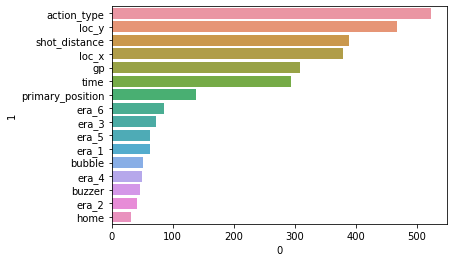

In [57]:
imp = pd.DataFrame(zip(pipe.steps[1][1].feature_importances_,X_train.columns))

sns.barplot(x=0, y=1, data=imp.sort_values(by=0, ascending=False))

Text(69.0, 0.5, 'Actual')

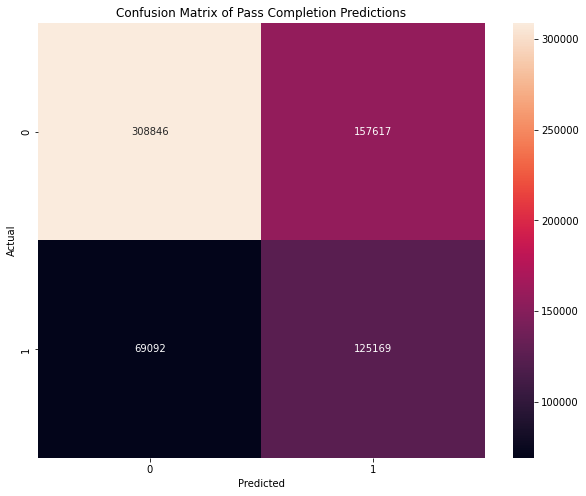

In [64]:
cm = confusion_matrix(np.round(preds[:,-1]), df["shot_made_flag"])

fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(cm, annot=True, fmt='g')

plt.title('Confusion Matrix of Pass Completion Predictions')
plt.xlabel('Predicted')
plt.ylabel('Actual')